In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

  
#function for calculating the uplift
def calc_uplift(df):
    avg_order_value = 25
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
    
    if len(df[df.offer == 'Buy One Get One']['conversion']) > 0:
          
        print('-------------- \n')
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))     
        

C:\Users\Haresh\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df_data = pd.read_csv('data.csv')
df_data.count()

recency          64000
history          64000
used_discount    64000
used_bogo        64000
zip_code         64000
is_referral      64000
channel          64000
offer            64000
conversion       64000
dtype: int64

In [3]:
#Calculating benchmark values
calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


In [4]:
df_data['campaign_group'] = 'treatment'
df_data.loc[df_data.offer == 'No Offer', 'campaign_group'] = 'control'
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment
1,6,329.08,1,1,Rural,1,Web,No Offer,0,control
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,treatment
3,9,675.83,1,0,Rural,1,Web,Discount,0,treatment
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment


In [5]:
df_data['target_class'] = 0 #CN
df_data.loc[(df_data.campaign_group == 'control') & (df_data.conversion > 0),'target_class'] = 1 #CR
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion == 0),'target_class'] = 2 #TN
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion > 0),'target_class'] = 3 #TR

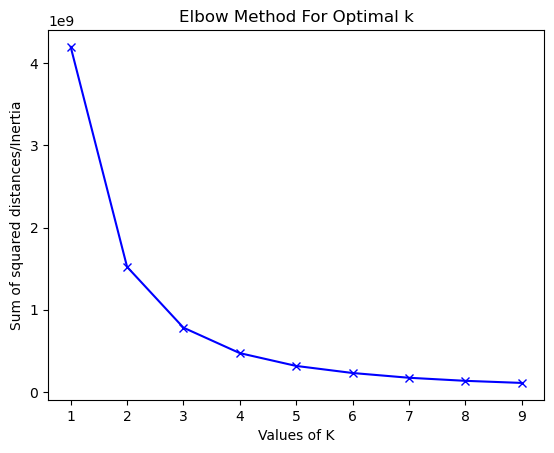

In [6]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_data['history'].values.reshape(-1,1))
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [7]:
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_data[['history']])
df_data['history_cluster'] = kmeans.predict(df_data[['history']])
#order the clusters
df_data = order_cluster('history_cluster', 'history',df_data,True)
#creating a new dataframe as model and dropping columns that defines the label
df_model = df_data.drop(['offer','campaign_group','conversion'],axis=1)
#convert categorical columns
df_model = pd.get_dummies(df_model)

In [8]:
df_model

,recency,history,used_discount,used_bogo,is_referral,target_class,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,2,0,0,1,0,0,1,0
1,2,45.34,1,0,0,2,0,0,0,1,0,0,1
2,6,134.83,0,1,0,3,0,0,1,0,0,1,0
3,9,46.42,0,1,0,2,0,0,0,1,0,1,0
4,10,32.84,0,1,1,2,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,2,1399.97,1,1,1,1,4,0,1,0,0,1,0
63996,1,1584.31,1,0,1,2,4,0,1,0,1,0,0
63997,1,1252.19,1,0,1,3,4,0,0,1,0,1,0
63998,2,1183.05,1,1,1,0,4,1,0,0,0,1,0


In [9]:
#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

C:\Users\Haresh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Haresh\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:05:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [28]:
class_probs[0]

array([0.33454672, 0.02676235, 0.5475904 , 0.09110057], dtype=float32)

In [29]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))
#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')
#assign it back to main dataframe
df_data['uplift_score'] = df_model['uplift_score']

In [38]:
df_data_lift = df_data.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)
print(df_data_lift.count())
#calculate the uplift
calc_uplift(df_data_lift)

recency            11618
history            11618
used_discount      11618
used_bogo          11618
zip_code           11618
is_referral        11618
channel            11618
offer              11618
conversion         11618
campaign_group     11618
target_class       11618
history_cluster    11618
uplift_score       11618
dtype: int64
Discount Conversion Uplift: 30.56%
Discount Order Uplift: 1374.05
Discount Revenue Uplift: $34351.28



In [34]:
df_data_lift = df_data.copy()
uplift_q_5 = df_data_lift.uplift_score.quantile(0.5)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score < uplift_q_5)].reset_index(drop=True)
print(df_data_lift.count())
#calculate the uplift
calc_uplift(df_data_lift)

recency            20216
history            20216
used_discount      20216
used_bogo          20216
zip_code           20216
is_referral        20216
channel            20216
offer              20216
conversion         20216
campaign_group     20216
target_class       20216
history_cluster    20216
uplift_score       20216
dtype: int64
Discount Conversion Uplift: -3.45%
Discount Order Uplift: -404.29
Discount Revenue Uplift: $-10107.36



In [41]:
df_data_lift

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,3,58.13,1,0,Urban,1,Web,No Offer,1,control,1,0,-0.336957
1,5,29.99,1,0,Surburban,0,Phone,Discount,0,treatment,2,0,-0.208065
2,9,112.35,1,0,Rural,0,Web,Discount,0,treatment,2,0,-0.214142
3,9,29.99,0,1,Surburban,1,Phone,No Offer,0,control,0,0,-0.239703
4,6,128.01,0,1,Urban,0,Web,Discount,0,treatment,2,0,-0.209747
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20236,1,1173.93,1,0,Urban,1,Multichannel,Discount,0,treatment,2,4,-0.687438
20237,1,1788.90,0,1,Surburban,1,Phone,Discount,0,treatment,2,4,-0.860857
20238,1,2039.13,0,1,Rural,1,Web,Discount,0,treatment,2,4,-0.864107
20239,2,1200.44,0,1,Surburban,1,Multichannel,Discount,0,treatment,2,4,-0.285324


In [36]:
def qini_rank(uplift): 
    # Function to Rank the data by the uplift score
    ranked = pd.DataFrame({'ranked uplift':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    ranked['ranked uplift'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='ranked uplift').reset_index(drop=True)
    return ranked

def qini_eval(ranked):
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['ranked uplift'] * uplift_model['uplift'].iloc[-1],5)
    
    uplift_model['Number_of_exposed_customers'] = np.arange(len(uplift_model))+1
    uplift_model['visits_gained'] = uplift_model.uplift*len(uplift_model)
    
    # Add q0
    q0 = pd.DataFrame({'ranked uplift':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='ranked uplift').reset_index(drop = True)
    return merged, uplift_model

def uplift_curve(uplift_model):
    plt.figure(figsize = (10,6))
    # plot the data
    ax = uplift_model['visits_gained'].plot(color=['#2077B4'])
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Number of customers treated')
    plt.ylabel('Incremental visits')
    plt.grid(b=True, which='major')
    return ax

def qini_plot(merged:pd.DataFrame, uplift_model:pd.DataFrame):
    gain_x = uplift_model['ranked uplift']
    gain_y = uplift_model.uplift
    qini = auc(gain_x, gain_y)
    # plot the data
    plt.figure(figsize = (10,6))
    mpl.rcParams['font.size'] = 8
    qini = auc(gain_x, gain_y)

    ax = plt.plot(gain_x, gain_y, color= '#2077B4',
        label='Normalized Uplift Model, Qini Score: {}'.format(round(qini,2)))
    
    plt.plot([0, gain_x.max()], [0, gain_y.max()],
        '--', color='tab:orange',
        label='Random Treatment')
    plt.legend()
    plt.xlabel('Porportion Targeted')
    plt.ylabel('Uplift')
    plt.grid(b=True, which='major')

    return ax

def plot_uplift(result:pd.DataFrame):
    # Function to plot the uplift curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax1 = uplift_curve(uplift_model)
    
    return ax1

def plot_qini(result:pd.DataFrame):
    # Function to plot the qini curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax2 = qini_plot(merged, uplift_model)
    
    return ax2 

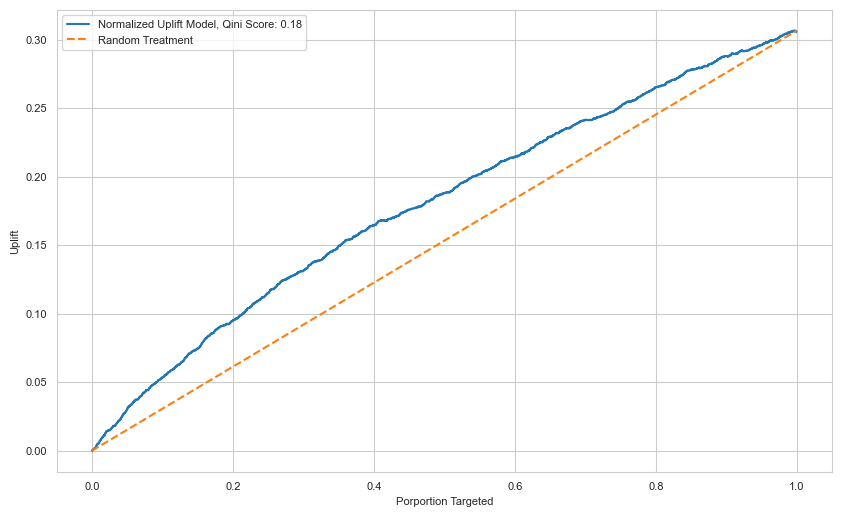

In [41]:
from sklearn.metrics import auc
import matplotlib as mpl
plot_qini(df_data_lift)
#plot_uplift(discount_uplift)

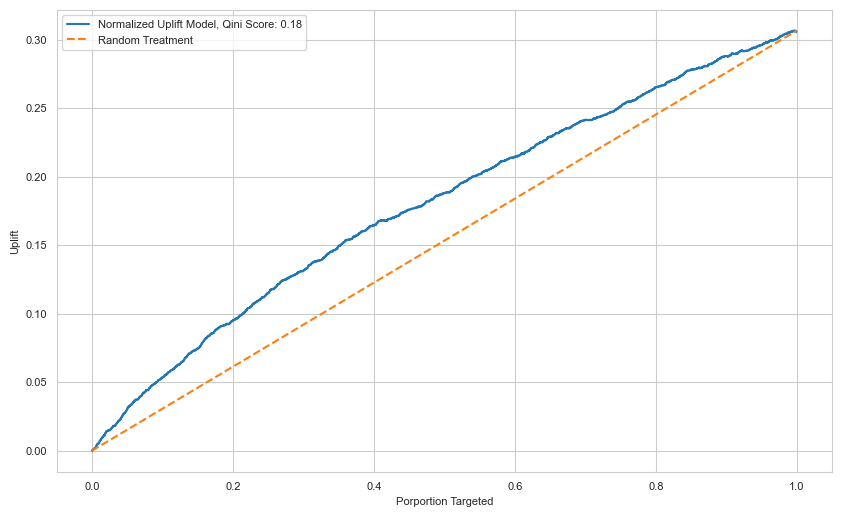

In [42]:
plot_qini(df_data_lift)

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()